### 准备数据集 [OpenFOAM, 圆柱绕流]

雷诺数 = 100 (u = 1, d = 1, $\nu$ = 0.01)

边界条件：
1. U
   1. Up and Down: symmetry
   2. Left: fixedValue uniform (1 0 0)
   3. Right: zeroGradient
   4. Cylinder: noSlip
2. P
   1. Up and Down: symmetry
   2. Left: zeroGradient
   3. Right: fixedValue uniform 0
   4. Cylinder: zeroGradient

速度场
<video controls src="assets/videos/U_magnitude.mp4" title="Title"></video>

### 数据处理

需要将流场数据转换为神经网络可以处理的数据格式：
1. 忽略空间信息，将时间和空间分别作为矩阵的行和列，构建这样一个大时空矩阵
2. 使用resample方法将流场数据采样到均匀的网格上

一般的，使用涡量来描述圆柱绕流，对于二维流场来说，涡量计算如下：
$$
\omega = \frac{\partial u}{\partial y} - \frac{\partial v}{\partial x}
$$

<video controls src="assets/videos/vorticity.mp4" title="Title"></video>

In [ ]:
import numpy as np

NSAMPLES = 1000
NX = 256
NY = 128

dataset = np.zeros((NX*NY, NSAMPLES))
for i in range(NSAMPLES):
    dataset[:, i] = np.genfromtxt(f'data/dataset/data_{i}.csv', skip_header=1, delimiter=',')[:, 2]

np.save('data/vorticity_dataset.npy', dataset)

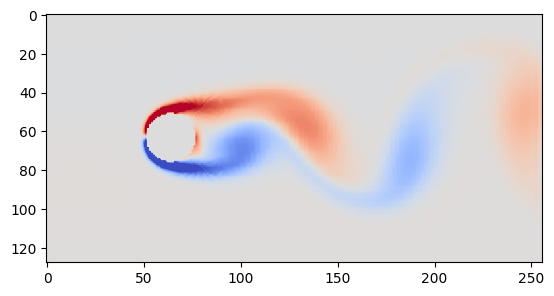

In [3]:
import numpy as np
import matplotlib.pyplot as plt

dataset = np.load('data/vorticity_dataset.npy')

import matplotlib.pyplot as plt
plt.imshow(dataset[:, -1].reshape(NY, NX), cmap='coolwarm', vmin=-5, vmax=5)
plt.show()

### 神经网络模型

直接对这样一个时间序列数据构建神经网络模型，对于这样矩阵化的数据格式，使用卷积神经网络构建模型是非常自然的选择，此外，卷积算子还和有限差分中的差分模板等价

In [28]:
import numpy as np
import torch
from torch import nn


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, 1, 1),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

dataset = np.load('data/vorticity_dataset.npy')  # (NX*NY, NSAMPLES)
dataset = torch.tensor(dataset, dtype=torch.float32)

NX = 256
NY = 128
NSAMPLES = 1000

model = CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    input = dataset[:, 0:500].reshape(-1, 1, NY, NX)
    output = dataset[:, 1:501].reshape(-1, 1, NY, NX)

    optimizer.zero_grad()
    pre_out = model(input)
    loss = criterion(output, pre_out)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')

torch.save(model.state_dict(), 'data/vorticity_cnn_model.pth')

Epoch 0, Loss: 1.3630857467651367
Epoch 1, Loss: 1.2015389204025269
Epoch 2, Loss: 1.0513914823532104
Epoch 3, Loss: 0.9127454161643982
Epoch 4, Loss: 0.7858056426048279
Epoch 5, Loss: 0.6707637906074524
Epoch 6, Loss: 0.5677922368049622
Epoch 7, Loss: 0.4770154654979706
Epoch 8, Loss: 0.39847448468208313
Epoch 9, Loss: 0.3320905566215515
Epoch 10, Loss: 0.2776339054107666
Epoch 11, Loss: 0.2346651405096054
Epoch 12, Loss: 0.20248828828334808
Epoch 13, Loss: 0.18012258410453796
Epoch 14, Loss: 0.16630564630031586
Epoch 15, Loss: 0.15952417254447937
Epoch 16, Loss: 0.1580679565668106
Epoch 17, Loss: 0.16012485325336456
Epoch 18, Loss: 0.163909912109375
Epoch 19, Loss: 0.16782714426517487
Epoch 20, Loss: 0.17060092091560364
Epoch 21, Loss: 0.17135660350322723
Epoch 22, Loss: 0.16964057087898254
Epoch 23, Loss: 0.16538088023662567
Epoch 24, Loss: 0.15880891680717468
Epoch 25, Loss: 0.15037094056606293
Epoch 26, Loss: 0.1406315118074417
Epoch 27, Loss: 0.13018988072872162
Epoch 28, Loss: 0

C:\Users\40841\AppData\Local\Temp\ipykernel_14092\2840680587.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('data/vorticity_cnn_model.

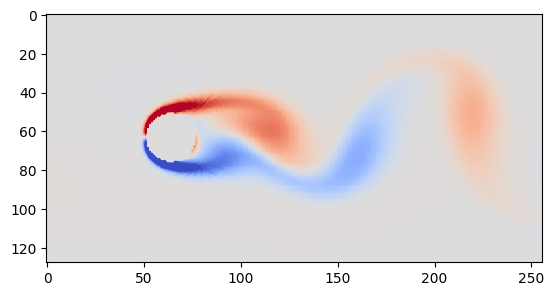

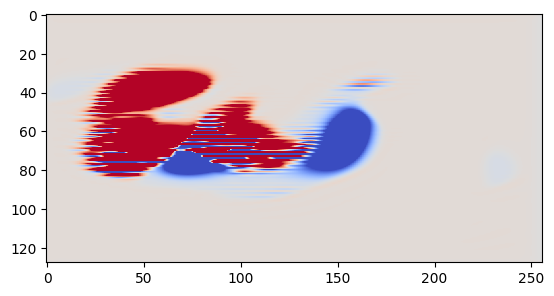

In [31]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn as nn
import numpy as np

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, 1, 1),
        )

    def forward(self, x):
        x = self.conv(x)
        return x
    
model = CNN()
model.load_state_dict(torch.load('data/vorticity_cnn_model.pth'))
model.eval()

dataset_np = np.load('data/vorticity_dataset.npy')  # (NX*NY, NSAMPLES)
dataset = torch.tensor(dataset_np, dtype=torch.float32)
NX = 256
NY = 128
NSAMPLES = 1000

true = dataset[:, 500].reshape(-1, 1, NY, NX)

fig_true, ax_true = plt.subplots()
im_true = ax_true.imshow(dataset_np[:, 500].reshape(NY, NX), cmap='coolwarm', vmin=-5, vmax=5)

fig_pre, ax_pre = plt.subplots()
im_pre = ax_pre.imshow(dataset_np[:, 500].reshape(NY, NX), cmap='coolwarm', vmin=-5, vmax=5)

def update_ture(i):
    im_true.set_array(dataset_np[:, 500+i].reshape(NY, NX))
    return im_true,

def update_pre(i):
    global true
    pre = model(true)
    true = pre
    im_pre.set_array(pre.detach().numpy().reshape(NY, NX))
    return im_pre,

ani_true = animation.FuncAnimation(fig_true, update_ture, frames=100, interval=10, blit=True)
ani_true.save('data/vorticity.gif', writer='pillow')

ani_pre = animation.FuncAnimation(fig_pre, update_pre, frames=100, interval=10, blit=True)
ani_pre.save('data/vorticity_pre.gif', writer='pillow')


true

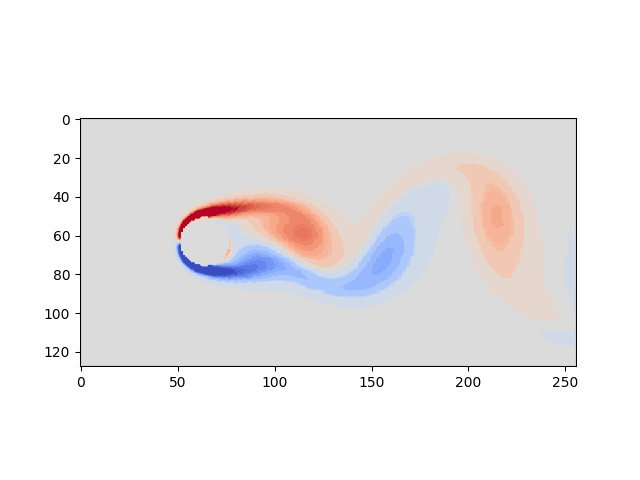

model predict

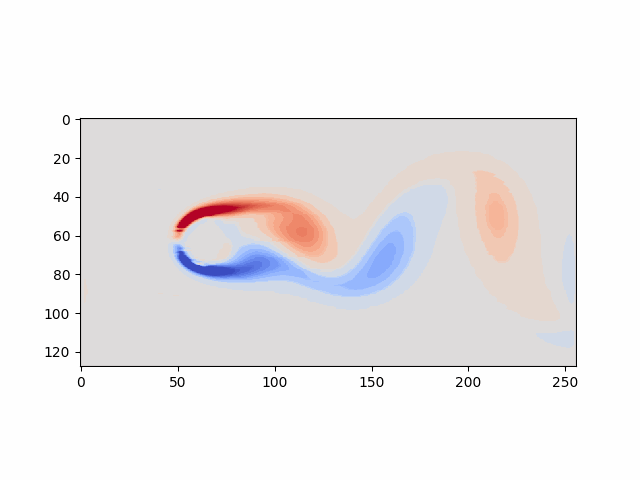

# **PINN**
Physical Informed Neural Network (物理信息神经网络)

使用神经网络描述 $\bm u = f(\bm x)$ 这样一个映射关系，通过神经网络任意阶可微分机制，直接将 $f(\bm x)$的表达式直接作为误差函数，从而运行神经网络。

# **自动求导**
**自动求导（Automatic Differentiation, AD）** 是一种高效计算函数导数的技术，广泛应用于机器学习、优化和科学计算中。深度学习框架（如 TensorFlow、PyTorch 等）正是通过自动求导实现模型的梯度计算，从而支持反向传播算法。

---

## **自动求导的核心概念**

自动求导的目标是计算函数的导数或梯度，但与数值方法（如有限差分）或符号方法（如数学解析求解）不同，它通过对计算过程的分解和跟踪计算的方式，直接得到导数的精确值。其关键特点包括：

1. **数值精确**：自动求导基于链式法则，避免了数值求导中的截断误差。
2. **高效计算**：通过记录计算图，自动求导可以高效地计算标量函数对向量输入的梯度（尤其是高维问题）。
3. **灵活性**：支持任意复杂的函数，只要函数由基本的数学运算和已知导数的操作组成。

---

## **自动求导的实现方式**

自动求导的核心是通过 **计算图（Computational Graph）** 表示函数的计算过程，并利用 **链式法则** 在节点之间计算导数。它通常有两种主要实现方式：

### 1. **前向模式自动求导（Forward Mode AD）**
- **特点**：从输入到输出逐步计算导数。
- **适用场景**：适合输入维度小、输出维度大的问题（例如标量输出函数）。
- **工作原理**：
  假设有一个函数 $f(x_1, x_2)$，其计算过程为：
  $$
  x_1 \xrightarrow{\text{操作 } g} v_1 \xrightarrow{\text{操作 } h} v_2 \xrightarrow{\text{操作 } k} y,
  $$
  通过链式法则计算 $y$ 对输入的导数 $\frac{\partial y}{\partial x_1}, \frac{\partial y}{\partial x_2}$。

  在计算的过程中，每一步都同时计算变量的值和对应的导数。例如：
  - $v_1 = g(x_1, x_2)$, $\dot{v}_1 = \frac{\partial g}{\partial x_1} \dot{x}_1 + \frac{\partial g}{\partial x_2} \dot{x}_2$。

### 2. **反向模式自动求导（Reverse Mode AD）**
- **特点**：从输出到输入逐步计算导数（即 **反向传播**）。
- **适用场景**：适合输出维度小、输入维度大的问题（如深度学习中的标量损失函数对高维参数的梯度）。
- **工作原理**：
  与前向模式类似，反向模式也基于链式法则，但它先计算前向传播（即计算输出值），然后逆序计算每个中间变量对输出的导数。

  举例来说，对于同一函数 $f(x_1, x_2)$，反向模式会：
  1. 在前向传播中记录所有中间变量的值（如 $v_1, v_2, y$）。
  2. 在反向传播中，从输出 $y$ 开始，逐步向前计算每个中间变量的导数：
     - $\frac{\partial y}{\partial x_1} = \frac{\partial y}{\partial v_2} \cdot \frac{\partial v_2}{\partial v_1} \cdot \frac{\partial v_1}{\partial x_1}$。

---

## **自动求导的示例**

假设有一个简单函数：

$$
y = x_1^2 + 2x_1x_2 + \sin(x_2),
$$

### 1. **前向模式**
- 计算图表示：
  - $v_1 = x_1^2$，$v_2 = 2x_1x_2$，$v_3 = \sin(x_2)$，$y = v_1 + v_2 + v_3$。
- 求导：
  - $\frac{\partial v_1}{\partial x_1} = 2x_1$, $\frac{\partial v_2}{\partial x_1} = 2x_2$, $\frac{\partial v_3}{\partial x_1} = 0$。
  - $\frac{\partial y}{\partial x_1} = \frac{\partial v_1}{\partial x_1} + \frac{\partial v_2}{\partial x_1} + \frac{\partial v_3}{\partial x_1}$。

### 2. **反向模式**
- 计算图记录：
  - 前向传播：计算 $v_1, v_2, v_3, y$ 的值。
  - 反向传播：从 $y$ 出发，计算 $\frac{\partial y}{\partial v_3}, \frac{\partial y}{\partial v_2}, \frac{\partial y}{\partial v_1}$，再逐步向前传播。

---

## **深度学习中的应用**

在深度学习中，自动求导是实现 **反向传播（Backpropagation）** 的核心。以下是其应用于深度学习的关键步骤：

1. **前向传播**：
   - 构建计算图并计算损失函数值。
2. **反向传播**：
   - 从损失函数出发，利用链式法则计算每个参数的梯度。
3. **梯度更新**：
   - 使用优化算法（如 SGD、Adam）更新模型参数。

In [37]:
"""
pytorch的自动求导
"""

import torch

# 定义一个标量张量（需要梯度计算）
x = torch.tensor(2.0, requires_grad=True)

# 定义一个简单的函数 y = x^2
y = x**2

# 自动求导：计算 dy/dx
y.backward()

# 输出梯度
print(f"x: {x}")
print(f"y: {y}")
print(f"dy/dx: {x.grad}")



x: 2.0
y: 4.0
dy/dx: 4.0


In [38]:
# 定义两个需要梯度的张量
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)

# 定义函数 z = x^2 + y^3
z = x**2 + y**3

# 自动求导：计算 dz/dx 和 dz/dy
z.backward()

# 输出梯度
print(f"x.grad (dz/dx): {x.grad}")
print(f"y.grad (dz/dy): {y.grad}")

x.grad (dz/dx): 4.0
y.grad (dz/dy): 27.0


# 使用神经网络表示PDEs

稳态不可压缩二维NS方程：

$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0 \\
u\frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = - \frac{\partial p}{\partial x} + \nu(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}) \\
u\frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = - \frac{\partial p}{\partial y} + \nu(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2})
$$

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net_u = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.net_v = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.net_p = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x, y):
        position = torch.cat((x, y), dim=1)
        u = self.net_u(position)
        v = self.net_v(position)
        p = self.net_p(position)
        return u, v, p
    

def compute_loss(u, v, p, x, y, nu=0.01):
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, torch.ones_like(v), create_graph=True)[0]
    p_x = torch.autograd.grad(p, x, torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y, torch.ones_like(p), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, torch.ones_like(v_y), create_graph=True)[0]
    loss_continuity = torch.mean(u_x + v_y)
    loss_momentum_x = torch.mean(u*u_x + v*u_y + p_x - nu*(u_xx + u_yy))
    loss_momentum_y = torch.mean(u*v_x + v*v_y + p_y - nu*(v_xx + v_yy))
    total_loss = loss_continuity + loss_momentum_x + loss_momentum_y
    return total_loss

def boundary_condition(x, y):
    return 0.0, 0.0, 0.0


net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.01)

for epoch in range(1000):
    x = torch.rand(100, 1)
    y = torch.rand(100, 1)
    u, v, p = net(x, y)
    loss = compute_loss(u, v, p, x, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')


